# Conditional VAE

So far, the variational autoencoder generates samples from random classes. What if we want to generate images from a particular class? This can be done by conditioning on the class labels during training. Formally, let \(\mathbf{y}\) denote the class label of image $\mathbf{x}$. We want to optimize $p(\mathbf{x}|\mathbf{y})$. The variational lower bound for the conditional distribution \(p(\mathbf{x}|\mathbf{y})\) becomes:

$$\log p(\mathbf{x}|\mathbf{y}) \geq \mathbb{E}_{\mathbf{z}\sim q_{\phi}(\mathbf{z}|\mathbf{x}, \mathbf{y})} [\log p_{\theta}(\mathbf{x}|\mathbf{y}, \mathbf{z})] - \mathcal{D}_{KL}(q_{\phi}(\mathbf{z}|\mathbf{x}, \mathbf{y}) \| p(\mathbf{z}|\mathbf{y}))$$

Thus, both the encoder and decoder must now incorporate the class label as input. This is done by embedding the label and concatenating it with both the image and the latent vector.

## Conditional VAE Architecture

We implement and test a conditional VAE on the MNIST dataset, following the architecture shown in Figure 1.

<div style="display: flex; justify-content: center;">
 <img src="/Users/raymondtsao/Desktop/UnsupervisedLearningNotes/notes/VAE/figures/cond_VAE_architecture.png" style="max-width: 45%; height: auto;">  
</div>

<p style="text-align: center; font-size: 14px; margin-top: 20px;"> 
    <strong> Figure 1 </strong>: Conditional VAE encoder and decoder architecture.
</p>


## Conditional VAE Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from ConditionalVAE import *

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
class ConditionalEncoder(nn.Module):
    """
    Implementation of conditional encoder
    """
    def __init__(self, in_channels, latent_dim, n_classes):
        """
        @param in_channels: int
        @param latent_dim: int
        @param n_classes: int
            Number of classes
        """
        super(ConditionalEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()
        )
        self.embedding = nn.Embedding(n_classes, latent_dim)
        self.linear = nn.Linear(4096 + latent_dim, 2 * latent_dim)
        self.n_classes = n_classes

    def forward(self, x, y):
        """
        @param x: torch.tensor [B, C, H, W]
        @param y: torch.tensor [B, ]
            The labels corresponding to the images
        """
        x = self.net(x)
        y = self.embedding(y)
        x = torch.cat([x, y], dim=1)
        x = self.linear(x)
        mu, log_std = torch.chunk(x, 2, dim=1)
        return mu, log_std

class ConditionalDecoder(nn.Module):
    """
    Implementation of conditional decoder
    """
    def __init__(self, in_channels, latent_dim, n_classes):
        """
        @param in_channels: int
        @param latent_dim: int
        @param n_classes: int
        """
        super(ConditionalDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, in_channels, 3, 1, 1),
            nn.Tanh()
        )
        self.embedding = nn.Embedding(n_classes, latent_dim)
        self.n_classes = n_classes

    def forward(self, z, y):
        """
        @param z: torch.tensor [B, L]
        @param y: torch.tensor [B, ]
        """
        y = self.embedding(y)
        x = self.net(z + y)
        return x

In [ ]:
class ConditionalVAE(nn.Module):
    """
    Implementation of conditional VAE class
    """
    def __init__(self, in_channels, latent_dim, n_classes, device="cpu"):
        """
        @param in_channels: int
        @param latent_dim: int
        @param n_classes: int
        """
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(in_channels, latent_dim, n_classes)
        self.decoder = Decoder(in_channels, latent_dim, n_classes)
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.device = device

    def forward(self, x, y):
        """
        @param x: torch.tensor [B, C, H, W]
        @param y: torch.tensor [B, ]
        """
        self.channels, self.height, self.width = x.shape[1:]
        mu_x, log_std_x = self.encoder(x, y)
        eps = torch.randn_like(mu_x)
        z = mu_x + log_std_x.exp() * eps
        x_recon = self.decoder(z, y)
        return x_recon, mu_x, log_std_x

    def sample(self, n, label):
        """
        @param n_samples: int
        """
        self.eval()
        z = torch.randn(n, self.latent_dim).to(self.device)
        samples = self.decoder(z, label)
        samples = torch.clamp((samples + 1) / 2, 0, 1)
        samples = samples.permute(0, 2, 3, 1)
        samples = samples.detach().cpu().numpy()
        return samples

## MNIST

We trained a conditional VAE with latent dimension of $256$. The model is trained for 5 epochs using Adam optimizer with a learning rate of $10^{-3}$. The generated samples, conditioned on each class, are shown in the figure below. The model successfully learns the conditional distribution of the handwritten digits.

In [ ]:
vae = VAE(1, 256, 10, device=DEVICE).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
train(vae, optimizer, train_loader, 5)

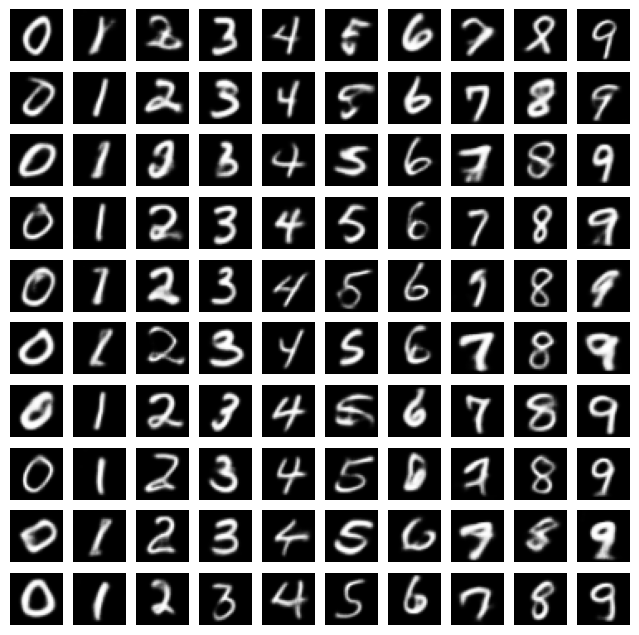

In [13]:
plot_samples(vae, device=DEVICE)

## Bibliography

[1] https://papers.nips.cc/paper_files/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf